# **COGS 189 Final Project: BCI Competition II Data Set IV**

**BCI Group 143**
- Thais Chen
- Kurtis Nguyen
- Riki Osawa

The notebook is written by:
- Isabella Gonzalez
- Kareema Kilani
- Daniel Milton

## Literature Review by Isabella and Daniel:

#### Single-trial EEG classification of motor imagery using deep convolutional neural networks:

   This paper describes a new method which they proposed that uses a deep convolutional neural network in order to do feature extraction and classification. They built a 5 layer cnn model to classify left and right hand movement. The results of this paper show that conovlutional neural networks has better classification performance than the other three more commonly used methods. 
   
https://www.sciencedirect.com/science/article/abs/pii/S0030402616312980

#### Designing optimal spatial filters for single-trial EEG classification in a movement task:

   This paper goes in depth about how using spatial filters for multi-channel EEG data can lead to signals to discriminate between two conditions. They showed the effectiveness of these filters by classifying EEGs of preparation of movements of the index fingers or the right foot. They used Common Spatial Patterns to get their results. They found that with these methods, they got high prediction rates which makes it to be a promising tactic.
   
https://www.sciencedirect.com/science/article/abs/pii/S1388245798000388
    

#### Classifying Single Trial EEG: Towards Brain Computer Interfacing:

   This is the paper where the data for the BCI competition was obtained from. In this experiment, "the subject sat in a normal chair, relaxed arms resting on the table, fingers in the standard typing position at the computer keyboard. The task was to press with the index and little fingers the corresponding keys in a self-chosen order and timing. The experiment consisted of 3 sessions of 6 minutes each, preand postceeded by 60 seconds relaxing phase." (Blankertz et al). 

https://proceedings.neurips.cc/paper/2001/file/2d579dc29360d8bbfbb4aa541de5afa9-Paper.pdf

#### BCI Competition 2003—Data Set IV:An Algorithm Based on CSSD and FDA for Classifying Single-Trial EEG

Since BCI Competetion II - Data Set IV is from 2001, it's a older format therefore  Ollie's created some code here for our data to work with. 

In [ ]:
#Use this cell to intsall any missing packages
#!pip install mne

# **Importing Packages**

In [ ]:
#Code from Ollie D'amico
import numpy as np
from itertools import chain
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Ollie's Code: Defining functions for later usage 

In [ ]:
def listFlatten(l):
    return list(chain.from_iterable(l))

def dc_correct(x):
    # Like baseline correction except it uses entire epoch mean
    nepochs, ntimes, nchans = x.shape
    bl_2D = np.mean(x, axis=1)
    bl_3D = np.transpose(np.repeat(bl_2D, ntimes).reshape(nepochs, nchans, ntimes), (0, 2, 1))

    return np.subtract(x, bl_3D)

def wm(x, start, end, num_points): # Modified from A2
    # Expects x = (num_obs x num_samples x num_channels)
    num_trials = x.shape[0]
    w = np.round((end-start)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials))
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    
    return y

### Loading in the Data from .mat files

In [ ]:
# Load mat
path = '/content/drive/MyDrive/COGS 189 Final Project/data/sp1s_aa.mat'

data = loadmat(path)

# Extract relevant pieces of data (y_test is from the website)
clab = data['clab']
x_train = data['x_train']
y_train = data['y_train'].reshape(-1,)
x_test = data['x_test']
y_test = np.array([1,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,1,0])

# Extract channels into a flattened list
chans = np.array(listFlatten(clab[0]))

In [ ]:
chans

array(['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2',
       'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5',
       'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2'], dtype='<U3')

#### The code below is orginally from Ollie however our group decided to modify it from our old work to plot multiple Event Related Potentials (ERP) of left and right hand movement for diffrent channels that are of intrest to our group.

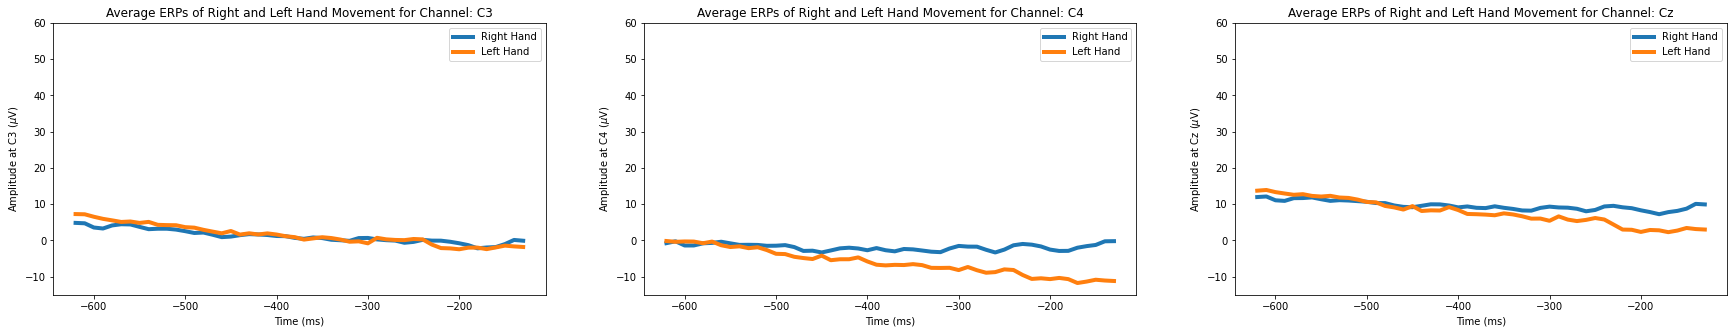

In [ ]:
# isolate C3 for plot

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 5))
counter = 0

for channel in ['C3', 'C4', 'Cz']:

  ch = np.where(chans == channel)[0][0] 

  # right hand movements are y_train == 1
  x_train_C3_R = x_train[:, ch, np.where(y_train == 1)]
  x_train_C3_L = x_train[:, ch, np.where(y_train == 0)]

  # Compute averages
  avg_C3_R = np.mean(x_train_C3_R, 2)
  avg_C3_L = np.mean(x_train_C3_L, 2)

  # Plot (right hand plot should look similar to paper's plot)
  fs = 100 # Hz
  dt = 1000./100 # msec
  times = np.arange(-120-500, -120, dt)
  

  axes[counter].plot(times, avg_C3_R, label = 'Right Hand', linewidth = 4);
  axes[counter].plot(times, avg_C3_L, label = 'Left Hand', linewidth = 4);
  axes[counter].set_ylim([-15, 60]);
  axes[counter].set_xlabel('Time (ms)');
  axes[counter].set_ylabel('Amplitude at ' + channel + ' ($\mu$V)');
  axes[counter].set_title('Average ERPs of Right and Left Hand Movement for Channel: ' + channel);
  axes[counter].legend(loc = "upper right")
  
  counter += 1

### Creating the training and testing arrays for classfication

In [ ]:
# Extract features
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
n_points = 3
win_e = -130
win_s = win_e - 210

# Index-space window start and end
w_s = np.where(times == win_s)[0][0]
w_e = np.where(times == win_e)[0][0]

# Transpose data for the wm function defined above
x_train_ = np.transpose(x_train, (2, 0, 1)) # for WM
x_test_ = np.transpose(x_test, (2, 0, 1)) # for WM

# Filter the data
fs = 100.0                                         
lp = 5.                       
order = 2                       

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, lp, analog = False, btype = 'low', output = 'sos', fs = fs)

x_train_.shape

# Apply 5 Hz lowpass
x_train_ = sosfiltfilt(sos, x_train_, axis= 1)
x_test_ = sosfiltfilt(sos, x_test_, axis= 1)

# Remove DC offset from each epoch
x_train_ = dc_correct(x_train_)
x_test_ = dc_correct(x_test_)

# Compute windowed means and flatten for sklearn
x_train_wm = wm(x_train_, w_s, w_e, n_points)
x_train_wm_ = x_train_wm.reshape(-1, len(chans)*n_points) 

x_test_wm = wm(x_test_, w_s, w_e, n_points)
x_test_wm_ = x_test_wm.reshape(-1, len(chans)*n_points)

x_train_wm_ = x_train_wm.reshape(-1, x_train_wm.shape[-1]).T
x_test_wm_ = x_test_wm.reshape(-1, x_test_wm.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(x_train_wm_.shape))
print('X_test  shape is now: ' + str(x_test_wm_.shape))

X_train shape is now: (316, 84)
X_test  shape is now: (100, 84)


# **Data Visulization with MNE**

In [ ]:
!pip install mne
import mne
x_train_new = np.transpose(x_train, (2, 1, 0))
x_train_new = sosfiltfilt(sos, x_train_new, axis= 1)
x_train_new
channels = ['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2',
       'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5',
       'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']
info = mne.create_info(
    ch_names = channels,
    ch_types = ['eeg']*28,
    sfreq = 100)
epochs = mne.EpochsArray(x_train_new, info)

     |████████████████████████████████| 7.4 MB 6.1 MB/s 
Not setting metadata
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [ ]:
sfreq = 100
eventlength = x_train_new.shape[0]
ev = [i*sfreq*0.01 for i in range(eventlength)]

events = np.column_stack((np.array(ev),
                         np.zeros(eventlength, dtype = int),
                         np.array(y_train)))
events = events.astype(int)

    Using multitaper spectrum estimation with 7 DPSS windows


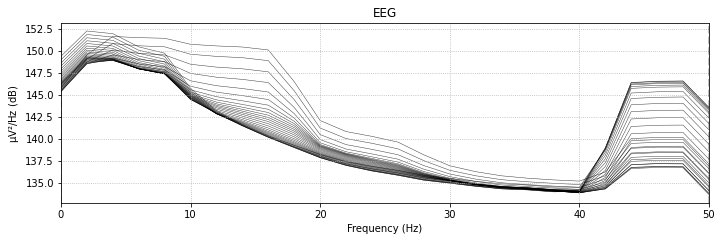

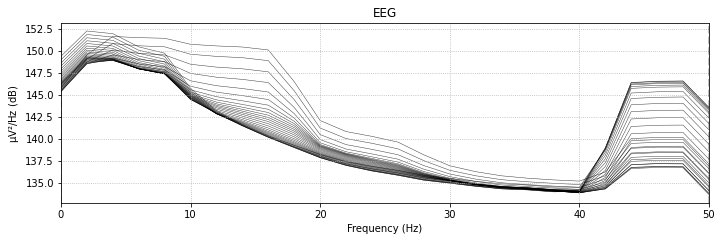

In [ ]:
epochs.plot_psd()

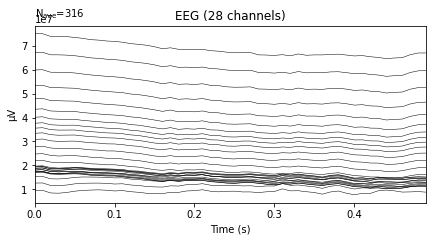

In [ ]:
epochs_plot = epochs.average().plot()

# **Classfication Models for Decoding** 

## **Linear Discriminant Analysis Classfication**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto')
score = cross_val_score(clf.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score)}')

# Predicting the Test set results
pred = clf.predict(x_test_wm_)
pred

# Overfitting just to get a rough idea of our classifier's performance
clf.score(x_train_wm_, y_train)

Cross val performance: 0.7849702380952379


0.8227848101265823

In [ ]:
clf = clf.fit(x_train_wm_, y_train)
clf.score(x_test_wm_, y_test)

0.78

### LDA ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = clf.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))

roc_auc_score for Random Forest:  0.8551420568227291


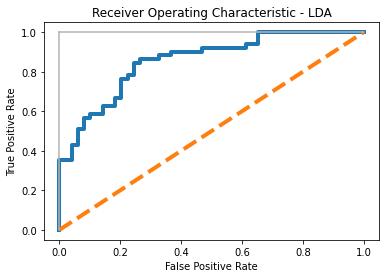

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - LDA')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LDA ROC Curve for 5 Fold Cross Validation

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas = clf.fit(X[train], y_train[train]).predict_proba(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

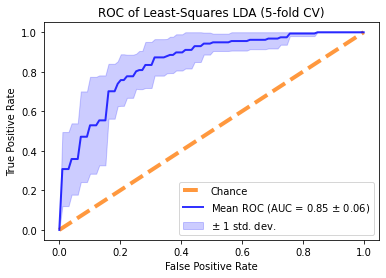

In [ ]:
# Modified from from Assignment 2:

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Least-Squares LDA (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### LDA Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

lsqrs_matrix = confusion_matrix(y_test, pred)

print(lsqrs_matrix)
#array that depicts the True Positives, False Positives, False Negatives, and True negatives.

[[39 10]
 [12 39]]


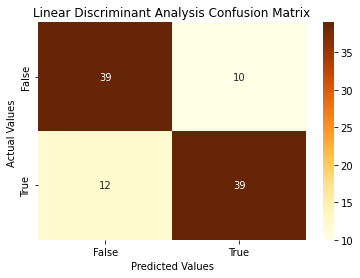

In [ ]:
import seaborn as sns

ax = sns.heatmap(lsqrs_matrix, annot=True, cmap = 'YlOrBr')

ax.set_title('Linear Discriminant Analysis Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'liblinear')
score_logreg = cross_val_score(logreg.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)

print(f'Cross val performance: {np.mean(score_logreg)}')

# Predicting the Test set results
pred_logreg = logreg.predict(x_test_wm_)
pred_logreg

Cross val performance: 0.7690972222222222


array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8)

In [ ]:
logreg.score(x_test_wm_, y_test)

0.76

### Logistic Regression ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = logreg.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)


print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))

roc_auc_score for Random Forest:  0.8159263705482193


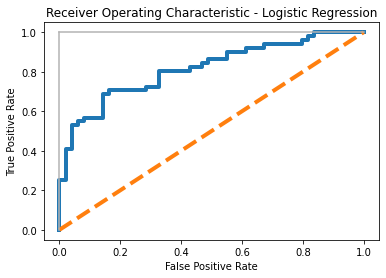

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression ROC Curve for 5 fold Cross Validation

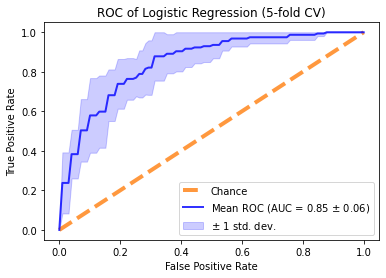

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas = logreg.fit(X[train], y_train[train]).predict_proba(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Logistic Regression (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

logreg_matrix = confusion_matrix(y_test, pred_logreg)

print(logreg_matrix)

[[41  8]
 [16 35]]


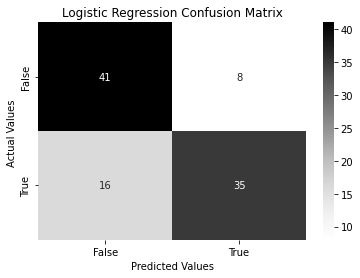

In [ ]:
ax = sns.heatmap(logreg_matrix, annot=True, cmap = 'Greys')

ax.set_title('Logistic Regression Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## **Random Forest Classification**

#### We're implememnting random forest as a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

### Random Forest Classification and accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data with dimensionality reduced to first feature
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(x_train_wm_, y_train)

score_classifier = cross_val_score(classifier.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_classifier)}')

# Predicting the Test set results
pred = classifier.predict(x_test_wm_)
pred

Cross val performance: 0.6396825396825396


array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], dtype=uint8)

In [ ]:
classifier.score(x_test_wm_, y_test)

0.61

### Random Forest ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = classifier.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)



print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))

roc_auc_score for Random Forest:  0.6578631452581034


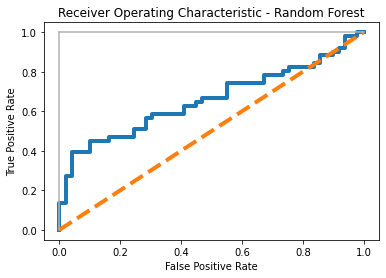

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest ROC Curve of 5 Fold Cross Validation

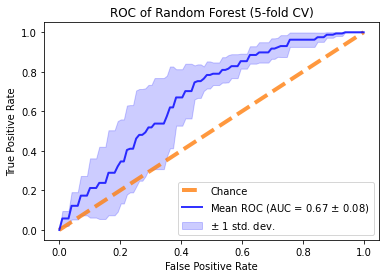

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas = classifier.fit(X[train], y_train[train]).predict_proba(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### Random Forest Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)
#array that depicts the True Positives, False Positives, False Negatives, and True negatives.

[[31 18]
 [21 30]]


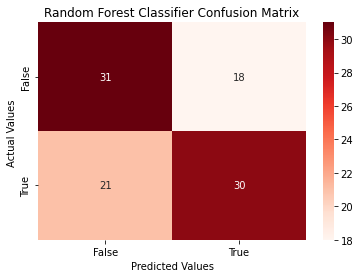

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Reds')

ax.set_title('Random Forest Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## **Support Vector Machines: Linear and Non Linear Classification**

### SVM: Linear Kernel Classification and Accuracy

In [ ]:
from sklearn.svm import LinearSVC

SVM = LinearSVC()
SVM.fit(x_train_wm_, y_train)

score_svm = cross_val_score(SVM.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_svm)}')

pred = SVM.predict(x_test_wm_)
pred

Cross val performance: 0.750297619047619


array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8)

In [ ]:
SVM.score(x_test_wm_, y_test)

0.67

### SVM (Linear Kernel): ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = classifier.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for SVM (Linear Kernel): ', roc_auc_score(y_test, y_score1))

roc_auc_score for SVM (Linear Kernel):  0.64265706282513


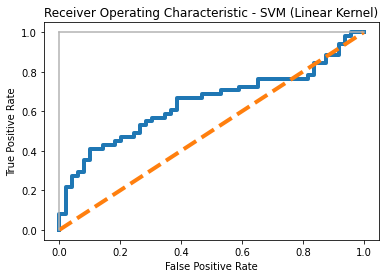

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - SVM (Linear Kernel)')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### SVM (Linear Kernel): ROC Curve of 5 Fold Cross Validation

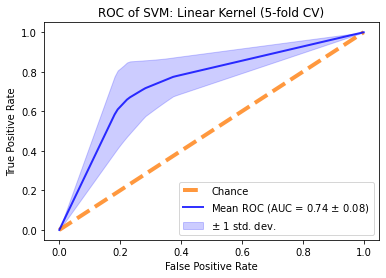

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas = SVM.fit(X[train], y_train[train]).predict(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM: Linear Kernel (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### SVM (Linear kernel): Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[37 12]
 [21 30]]


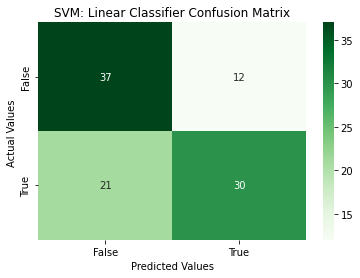

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Greens')

ax.set_title('SVM: Linear Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

### SVM: Radial Kernel Classification and Accuracy

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', probability=True)
svclassifier.fit(x_train_wm_, y_train)

score_svclassifier = cross_val_score(svclassifier.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_svclassifier)}')

pred = svclassifier.predict(x_test_wm_)

Cross val performance: 0.7092757936507936


In [ ]:
svclassifier.score(x_test_wm_,y_test)

0.72

### SVM (Radial Kernel): ROC Curve 

In [ ]:
y_score1 = svclassifier.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for non linear svc: ', roc_auc_score(y_test, y_score1))

roc_auc_score for non linear svc:  0.7767106842737096


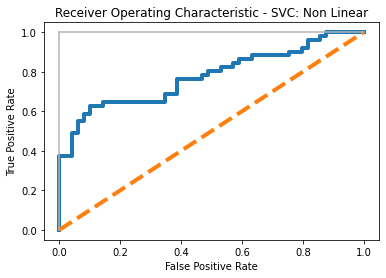

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - SVC: Non Linear')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### SVM (Radial Kernel): ROC Curve of 5 Fold Cross Validation

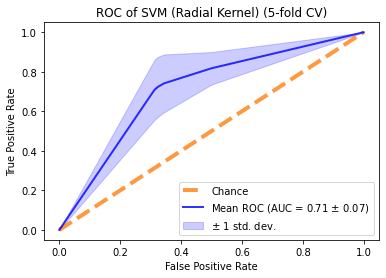

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas =  svclassifier.fit(X[train], y_train[train]).predict(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM (Radial Kernel) (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### SVM (Radial Kernel): Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[39 10]
 [18 33]]


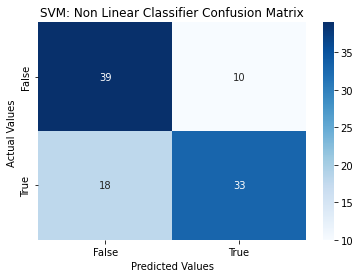

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('SVM: Non Linear Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## **Neural Network Classification**

### NN Training and accuracy score

In [ ]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(x_train_wm_, y_train)

score_NN = cross_val_score(NN.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_NN)}')

pred = NN.predict(x_test_wm_)
pred 

Cross val performance: 0.7027777777777778


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [ ]:
#Testing Data
NN.score(x_test_wm_, y_test)

0.63

### NN ROC curve

In [ ]:
y_score1 = NN.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for non linear svc: ', roc_auc_score(y_test, y_score1))

roc_auc_score for non linear svc:  0.6446578631452582


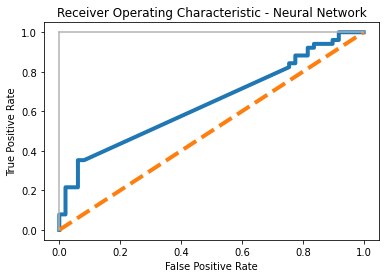

In [ ]:
plt.subplots(1)
plt.title('Receiver Operating Characteristic - Neural Network')
plt.plot(false_positive_rate1, true_positive_rate1, linewidth = 4)
plt.plot([0, 1], ls="--", linewidth = 4)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

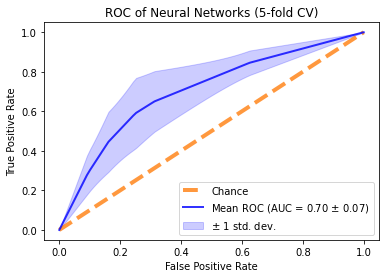

In [ ]:
# Modified from from Assignment 2:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = x_train_wm_
tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y_train):
    probas = NN.fit(X[train], y_train[train]).predict(X[test])
    fpr, tpr, th = roc_curve(y_train[test], probas[:])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='C1',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs);

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Neural Networks (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

### NN Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[45  4]
 [33 18]]


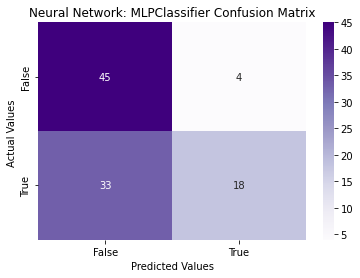

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Purples')

ax.set_title('Neural Network: MLPClassifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### **Trying to Reduce Dimensionality with PCA**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

pca = PCA()
Xtrain = pca.fit_transform(x_train_wm_)
xtest = pca.transform(x_test_wm_)

In [ ]:
#how much of the variance does the first feature have?
explained_variance = pca.explained_variance_ratio_
explained_variance[0] 
#explained variance for the first principal component is 78, which means 78% of the data's information is explained through this variable

0.7659916304129412

In [ ]:
explained_variances = []
for i in range(len(explained_variance)):
    explained_variances.append(explained_variance[i])
 
print(explained_variances)

[0.7659916304129412, 0.1080790308790372, 0.044429898277141215, 0.025032078854272343, 0.015898021807306574, 0.00778382685389526, 0.0059572676280278715, 0.005130045908395107, 0.003202946187609535, 0.0027125726887893787, 0.00226728004579751, 0.0016452463602999767, 0.0013130161501288217, 0.0012133272467146907, 0.0009893811073228196, 0.0009041695350254985, 0.0008215517555795208, 0.0007373654082320041, 0.0006675612683870158, 0.0005332157461574788, 0.00048031395703616023, 0.00047688806906380607, 0.0003706818398633004, 0.00029216349935272563, 0.0002760292313041583, 0.0002592599625017655, 0.00024592146007621635, 0.00023023404203600288, 0.00019443182103601439, 0.00018089082504598329, 0.00017254552645848723, 0.0001529011577668627, 0.00012804159621231993, 0.00012281499052665173, 0.00011583953081925926, 0.00010981584644915216, 0.00010139107037116401, 9.317660632506634e-05, 8.214579299665626e-05, 7.269943982202707e-05, 7.053627424994317e-05, 6.003719939400321e-05, 5.0805524886370166e-05, 4.420341818

In [ ]:
k=0
current=0
total=sum(explained_variances)
while current/total<0.96:
    current+=explained_variances[k]
    k+=1
k

6

^This shows that 65 out of 84 total principal components make up 96% of the data, so now we would want to try classifying with only those

### Using Only The First 65 Principal Components on Random Forest:

In [ ]:
#training data with first principal component
pca = PCA(n_components=65)
Xtrain = pca.fit_transform(x_train_wm_)
xtest = pca.transform(x_test_wm_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data with dimensionality reduced to first feature
classifier2 = RandomForestClassifier(max_depth=2, random_state=0)
classifier2.fit(x_train_wm_, y_train)

score_classifier2 = cross_val_score(classifier2.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_classifier2)}')

# Predicting the Test set results
pred = classifier2.predict(x_test_wm_)
pred

Cross val performance: 0.6396825396825396


array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], dtype=uint8)

In [ ]:
classifier2.score(x_test_wm_, y_test)

0.61

Out of 84 principal components, it takes 65 to explain 96% of the variance in the data, so we dont see much change in the accuracy of the classification algorithm. 

https://www.projectpro.io/recipes/plot-roc-curve-in-python
https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas/


# **Making A Pipeline**

We're using a pipeline is to assemble a sequence that can be cross-validated together while setting different parameters.

In [ ]:
#Packing for pipeline usage
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('PCA', PCA()), ('rand_forest', RandomForestClassifier()) ])

pipe_classifer = pipe.fit(x_train_wm_, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components = 65)), ('rand_forest', RandomForestClassifier())])

pipe.score(x_test_wm_, y_test)

0.67

In [ ]:
pipe_score = cross_val_score(pipe_classifer.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(pipe_score)}')

Cross val performance: 0.702579365079365
